# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.contrib.layers import flatten, xavier_initializer_conv2d
import time
import cv2
import numpy as np
import random
import math
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

---
## Step 0: Load The Data

In [3]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = 'train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [4]:
### Replace each question mark with the appropriate value.
import numpy as np

# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train.shape[1:]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

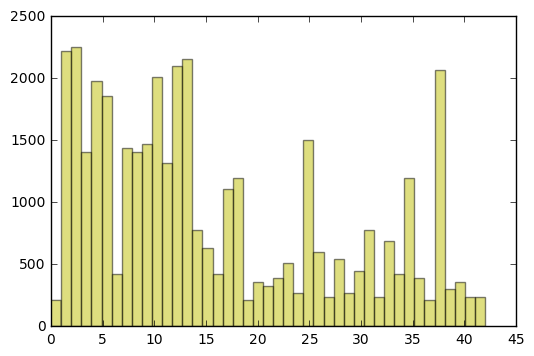

In [5]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
# Visualizations will be shown in the notebook.
num_bins = n_classes
# the histogram of the signs
n, bins, patches = plt.hist(y_train, num_bins, facecolor='y', alpha=0.5)

Observation: the training data is not balanced. The two most frequently occurring signs are 'Speed limit (30km/h)' and 
'Speed limit (50km/h)'.

In [6]:
import csv

signNames = []
with open('signnames.csv') as signfile:    
    reader = csv.reader(signfile)
    next(reader, None) #skip the header
    signNames = list(reader)

print('\n'.join([i + ': ' + s  for [i, s] in signNames]))  
#store in a dictionary for easy use later
signDict = dict(signNames)

0: Speed limit (20km/h)
1: Speed limit (30km/h)
2: Speed limit (50km/h)
3: Speed limit (60km/h)
4: Speed limit (70km/h)
5: Speed limit (80km/h)
6: End of speed limit (80km/h)
7: Speed limit (100km/h)
8: Speed limit (120km/h)
9: No passing
10: No passing for vehicles over 3.5 metric tons
11: Right-of-way at the next intersection
12: Priority road
13: Yield
14: Stop
15: No vehicles
16: Vehicles over 3.5 metric tons prohibited
17: No entry
18: General caution
19: Dangerous curve to the left
20: Dangerous curve to the right
21: Double curve
22: Bumpy road
23: Slippery road
24: Road narrows on the right
25: Road work
26: Traffic signals
27: Pedestrians
28: Children crossing
29: Bicycles crossing
30: Beware of ice/snow
31: Wild animals crossing
32: End of all speed and passing limits
33: Turn right ahead
34: Turn left ahead
35: Ahead only
36: Go straight or right
37: Go straight or left
38: Keep right
39: Keep left
40: Roundabout mandatory
41: End of no passing
42: End of no passing by vehic

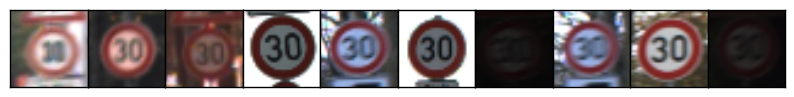

In [7]:
#visualize random 10 examples for class 1
sample_per_class = 10
fig = plt.figure(figsize=(sample_per_class, 1))
gs = gridspec.GridSpec(1, sample_per_class, wspace=0.0, hspace=0.0)
i = 1
class_i = y_train==i
x_class_i = X_train[class_i, ]
for j in range(sample_per_class):
    ax = plt.subplot(gs[0, j]) 
    ax.imshow(random.choice(x_class_i))
    ax.set_xticks([])
    ax.set_yticks([])        
    fig.add_subplot(ax)

plt.show()

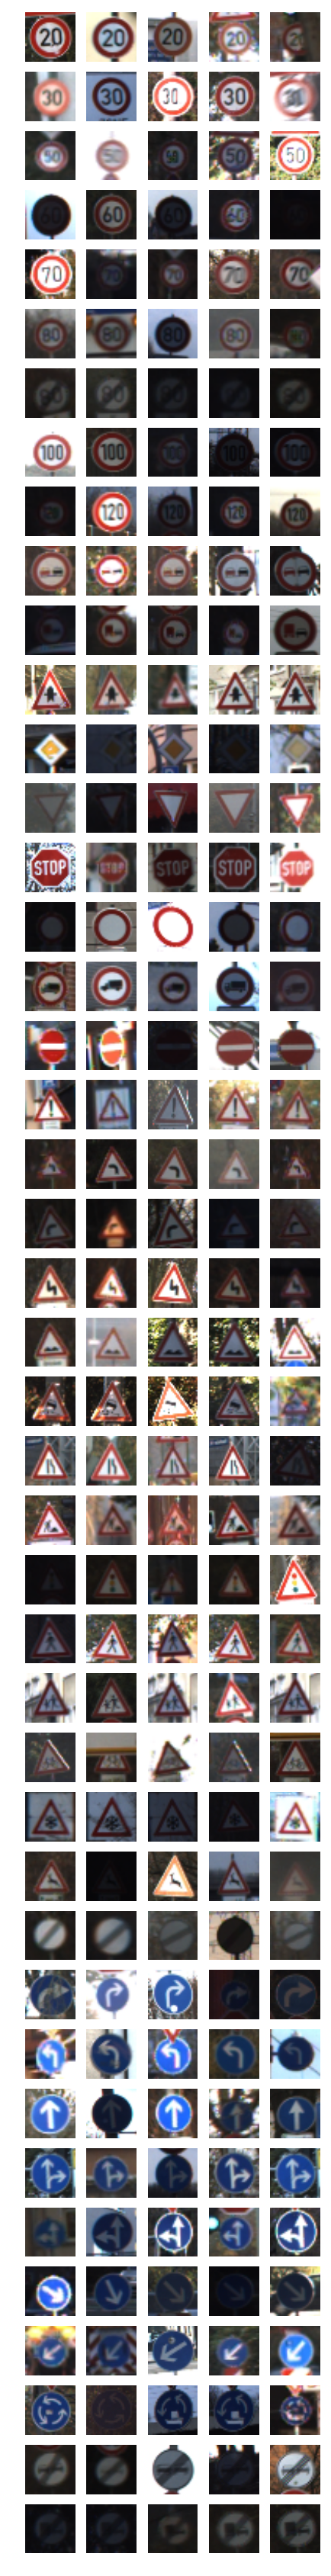

In [8]:
#visualize random 5 examples for each class
sample_per_class = 5
gs = gridspec.GridSpec(n_classes, sample_per_class)
fig = plt.figure(figsize=(sample_per_class, n_classes))
for i in range(n_classes):
    class_i = y_train==i
    x_class_i = X_train[class_i, ]
    for j in range(sample_per_class):               
        plt.subplot(n_classes,sample_per_class, i*sample_per_class+j+1)
        plt.imshow(random.choice(x_class_i))
        plt.axis('off')

plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [9]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.
# generate new image by rotating and translating an image
def jitter(img):    
    w, h = img.shape[0:2]     
    center = (w/2, h/2)
    output_shape = (w, h)
    
    # Rotation
    angle = int(random.random()*30.0) - 15
    rotM = cv2.getRotationMatrix2D(center, angle, 1)
    img = cv2.warpAffine(img, rotM, output_shape)
    
    # Translation
    x = int(random.random() * 4) - 2
    y = int(random.random() * 4) - 2
    transM = np.float32([[1, 0, x], [0, 1, y]])
    img = cv2.warpAffine(img, transM, output_shape)
    
    return img

In [10]:
#whether to generate new data, for the purpose of switching easily 
generate_data = True 

if generate_data:
    # use the original training data as validation data
    X_val = X_train
    y_val = y_train
    print('use train data as validation adta')

    #Generate about 5000 training data for each class
    num = 5000 #approximate number of training data to genereate per class
    total = 0 #total number of training data to generate
    for i in range(n_classes):
        class_i = y_val==i
        num_existing = sum(class_i)
        total += (num // num_existing) * num_existing
    print(total)

    X_train = np.zeros((total, 32, 32, 3))  
    y_train = np.zeros((total,)).astype(int)

    c = 0
    for i in range(n_classes):
        class_i = y_val==i
        x_class_i = X_val[class_i, ]
        num_existing = len(x_class_i)
        k = num // num_existing       
        for j in range(num_existing): 
            for l in range(k):
                #X_train[c + j * k + l, ] = jitter(x_class_i[j]) 
                X_train[c + j * k + l, ] = jitter(random.choice(x_class_i))
                y_train[c + j * k + l, ] = i
        c += k * num_existing
    print('Generated {} images as new training data'.format(total))

use train data as validation adta
196523
Generated 196523 images as new training data


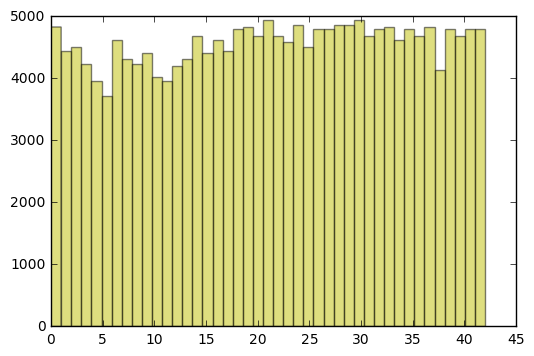

In [11]:
#take a look at the class distribution with new training data
n, bins, patches = plt.hist(y_train, num_bins, facecolor='y', alpha=0.5)

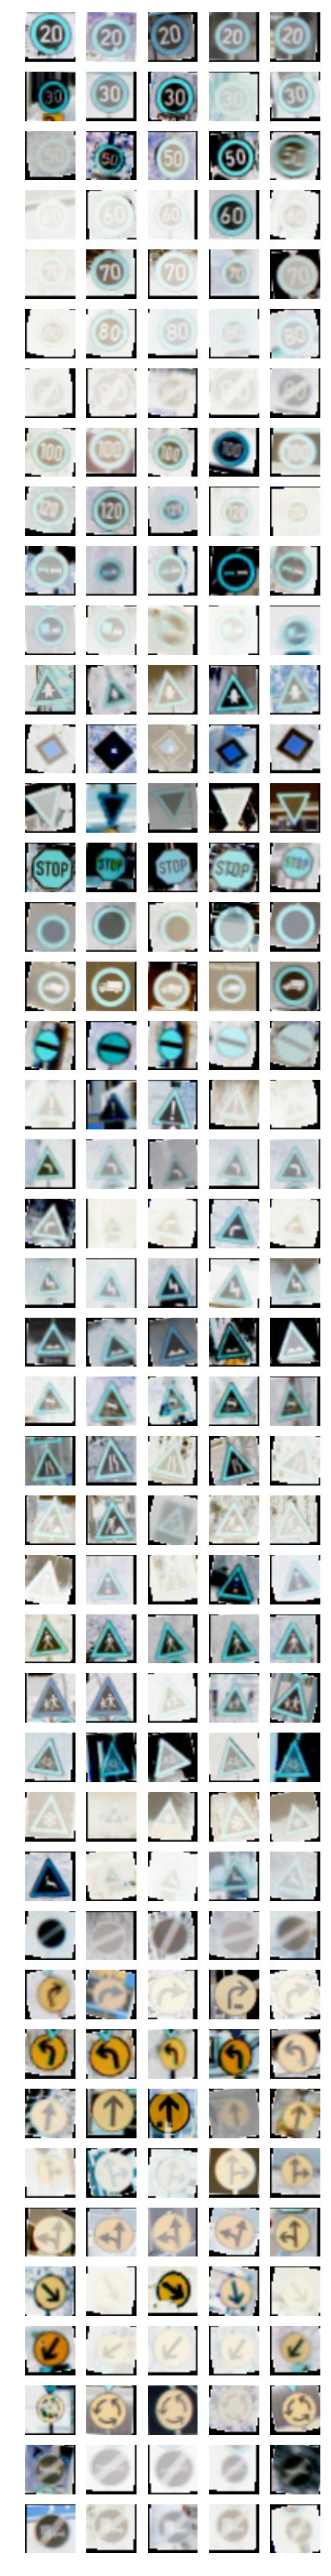

In [12]:
#visualize random 5 examples for the each class
sample_per_class = 5
gs = gridspec.GridSpec(n_classes, sample_per_class)
fig = plt.figure(figsize=(sample_per_class, n_classes))
for i in range(n_classes):
    class_i = y_train==i
    x_class_i = X_train[class_i, ]
    for j in range(sample_per_class):                
        plt.subplot(n_classes,sample_per_class, i*sample_per_class+j+1)
        plt.imshow(random.choice(x_class_i))
        plt.axis('off')

plt.show()

In [4]:
def grayscale(img):
     return cv2.cvtColor(img.astype(np.float32), cv2.COLOR_BGR2GRAY)

def normalize(image_data):
    """
    Normalize the image data with Min-Max scaling to a range of [-0.5, 0.5]
    :param image_data: The image data to be normalized
    :return: Normalized image data
    """
    a = -0.5
    b = 0.5
    x_min = np.min(image_data)
    x_max = np.max(image_data)
    return a + (image_data - x_min) * (b - a) / (x_max - x_min)    

In [16]:
X_train_gray = np.zeros([X_train.shape[0], X_train.shape[1], X_train.shape[2]])
for i in range (len(X_train)):
     X_train_gray[i] = grayscale(X_train[i])
    
X_test_gray = np.zeros([X_test.shape[0], X_test.shape[1], X_test.shape[2]])        
for i in range(len(X_test)):
    X_test_gray[i] = grayscale(X_test[i])    
print('converted train and test images to grayscale')    

X_train = X_train_gray.reshape(X_train_gray.shape + (1,))
X_test = X_test_gray.reshape(X_test_gray.shape + (1,))

X_train = normalize(X_train)
X_test = normalize(X_test)
print('normalized train and test data')

X_train, y_train = shuffle(X_train, y_train)
if generate_data:
    X_val_gray = np.zeros([X_val.shape[0], X_val.shape[1], X_val.shape[2]])        
    for i in range(len(X_val)):
        X_val_gray[i] = grayscale(X_val[i]) 
    print('converted validation images to grayscale')
    
    X_val = X_val_gray.reshape(X_val_gray.shape + (1,))
    X_val = normalize(X_val)
    print('normalized validation data')
else:    
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
    print('use 20% train data as validation data')
  
print('X_train.shape={}'.format(X_train.shape))
print('X_val.shape={}'.format(X_val.shape))
print('X_test.shape={}'.format(X_test.shape))    

converted train and test images to grayscale
normalized train and test data
converted validation images to grayscale
normalized validation data
X_train.shape=(196523, 32, 32, 1)
X_val.shape=(39209, 32, 32, 1)
X_test.shape=(12630, 32, 32, 1)


### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

My preprocessing includes converting the images to gray scale, and then normalizing the data to within the range of 
-0.5 and 0.5. I think it's important not to let the color of the images influence the classifier, and normalizing ensures
features are weighted equallly and helps with convergence as well.

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

Since the training data is not well balanced, some of the classes are more dominating than others, I generated new training data to make sure all classes are roughly equally balanced. For each class, I genereate about 5000 images by randomly selecting an image in the class from the existing training data, and then performed random rotation (up to 20 or -20 degrees) and random translation (up to +2 or -2 pixels in x and/or y axis). 

I then use the original training data as validation data. 

This idea comes from the published approach listed in the notebook: http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf 

In [21]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

# Please see code above

In [22]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

In [14]:
def conv2d(x, W, b, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='VALID')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='VALID')

layer_depth = {
    'layer_1': 16,
    'layer_2': 32,
    'layer_3': 512,
    'layer_4': 128      
}

#mu = 0.0
#sigma = 0.1

weights = {
    #'layer_1': tf.Variable(tf.truncated_normal([5, 5, 1, layer_depth['layer_1']], mean=mu, stddev=sigma), name='weights_1'),
    #'layer_2': tf.Variable(tf.truncated_normal([5, 5, layer_depth['layer_1'], layer_depth['layer_2']], mean=mu, stddev=sigma), name='weights_2'),
    #'layer_3': tf.Variable(tf.truncated_normal([5*5*32, layer_depth['layer_3']], mean=mu, stddev=sigma), name='weights_3'),
    #'layer_4': tf.Variable(tf.truncated_normal([layer_depth['layer_3'], layer_depth['layer_4']], mean=mu, stddev=sigma), name='weights_4'),
    #'out': tf.Variable(tf.truncated_normal([layer_depth['layer_4'], n_classes], mean=mu, stddev=sigma), name='weights_out')
    
    'layer_1': tf.Variable(xavier_initializer_conv2d()([5, 5, 1, layer_depth['layer_1']]), name='weights_1'),
    'layer_2': tf.Variable(xavier_initializer_conv2d()([5, 5, layer_depth['layer_1'], layer_depth['layer_2']]), name='weights_2'),
    'layer_3': tf.Variable(xavier_initializer_conv2d()([5*5*32, layer_depth['layer_3']]), name='weights_3'),
    'layer_4': tf.Variable(xavier_initializer_conv2d()([layer_depth['layer_3'], layer_depth['layer_4']]),  name='weights_4'),
    'out': tf.Variable(xavier_initializer_conv2d()([layer_depth['layer_4'], n_classes]),  name='weights_out')
}

biases = {
    'layer_1': tf.Variable(tf.zeros(layer_depth['layer_1']), name='bias_1'),
    'layer_2': tf.Variable(tf.zeros(layer_depth['layer_2']), name='bias_2'),
    'layer_3': tf.Variable(tf.zeros(layer_depth['layer_3']), name='bias_3'),
    'layer_4': tf.Variable(tf.zeros(layer_depth['layer_4']), name='bias_4'),
    'out': tf.Variable(tf.zeros(n_classes), name='bias_out')
}

def model(x, keep_prob):    
    # Layer 1: Convolutional and ReLU. Input = 32x32x1. Output = 28x28x16.   
    conv1 = conv2d(x, weights['layer_1'], biases['layer_1'])    
    
    # Pooling. Input = 28x28x16. Output = 14x14x16.
    conv1 = maxpool2d(conv1)
    # Dropout
    conv1 = tf.nn.dropout(conv1, keep_prob)
    
    # Layer 2: Convolutional and ReLU. Output = 10x10x32.    
    conv2 = conv2d(conv1, weights['layer_2'], biases['layer_2']) 
    # Pooling. Input = 10x10x32. Output = 5x5x32.
    conv2 = maxpool2d(conv2) 
    # Dropout
    conv2 = tf.nn.dropout(conv2, keep_prob)
    
    # Flatten. Input = 5x5x32. Output = 800.
    flattened = flatten(conv2)
    # Layer 3: Fully Connected. Input = 800. Output = 512.
    layer3 = tf.add(tf.matmul(flattened, weights['layer_3']), biases['layer_3'])    
    layer3 = tf.nn.relu(layer3)

    # Layer 4: Fully Connected. Input = 512. Output = 128.
    layer4 = tf.add(tf.matmul(layer3, weights['layer_4']), biases['layer_4'])
    # Activation.
    layer4 = tf.nn.relu(layer4)
    
    # Layer 5: Fully Connected. Input = 128. Output = 43.
    logits = tf.add(tf.matmul(layer4, weights['out']), biases['out'])
    return logits

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

The model is as follows:

#### INPUT -> CONV -> RELU -> POOL -> CONV -> RELU -> POOL-> FC -> RELU -> FC -> RELU -> FC

### Input

    A 32x32x1 image.

### Architecture

The modle consists of the following:

Layer 1: 5x5x6 Convolution. The output shape is 28x28x16.

        Activation: ReLU.

        2x2 Pooling: The output shape is 14x14x16.

        Dropout is applied. 

Layer 2: 5x5x32 Convolution. The output shape is 10x10x32.

        Activation: ReLU.

        2x2 Pooling. The output shape us 5x5x32.

        Dropout is applied.

Flatten: Flatten the output shape of the previous layer such that it's 1D instead of 3D. The output shape is 800. 

Layer 3: Fully Connected. The output shape is 512.

        Activation: ReLU.

Layer 4: Fully Connected. The output shape is 128.

        Activation: ReLU.

Layer 5: Fully Connected (Logits). This has 43 outputs.
    
### Output

    Return the result of the last fully connected layer.

Below is the graph produced by TensorBoard.

In [4]:
#<img src="graph.png", width=300, height=300, align="left"> #does not show in github
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "graph.png", width=300, height=300)

### Training Pipeline

In [15]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32, (None))
one_hot_y = tf.one_hot(y, n_classes)

In [16]:
EPOCHS = 15
BATCH_SIZE = 128
learning_rate = 0.001
#beta = 5e-4
#stepsPerEpoch = float(X_train.shape[0]) / BATCH_SIZE
#print('stepsPerEpoch={}'.format(stepsPerEpoch))
#num_steps = int(math.ceil(float(EPOCHS) * stepsPerEpoch))
#print('num_steps={}'.format(num_steps))

In [17]:
logits = model(x, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
#loss_operation += (beta * (tf.nn.l2_loss(weights['layer_1'])  + tf.nn.l2_loss(weights['layer_2']) 
#                          + tf.nn.l2_loss(weights['layer_3']) + tf.nn.l2_loss(weights['layer_4']) 
#                          + tf.nn.l2_loss(weights['out'])))

#global_step = tf.Variable(0)
#learning_rate = tf.train.exponential_decay(0.005, global_step, int(stepsPerEpoch) * 2, 0.96, staircase=True)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

training_operation = optimizer.minimize(loss_operation)

In [18]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):    
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Train the model

In [23]:
### Train your model here.
### Feel free to use as many code cells as needed.

Training...

EPOCH 1 ...
Training Accuracy = 0.941
Validation Accuracy = 0.933

EPOCH 2 ...
Training Accuracy = 0.975
Validation Accuracy = 0.976

EPOCH 3 ...
Training Accuracy = 0.984
Validation Accuracy = 0.980

EPOCH 4 ...
Training Accuracy = 0.988
Validation Accuracy = 0.986

EPOCH 5 ...
Training Accuracy = 0.992
Validation Accuracy = 0.990

EPOCH 6 ...
Training Accuracy = 0.994
Validation Accuracy = 0.990

EPOCH 7 ...
Training Accuracy = 0.991
Validation Accuracy = 0.985

EPOCH 8 ...
Training Accuracy = 0.990
Validation Accuracy = 0.985

EPOCH 9 ...
Training Accuracy = 0.996
Validation Accuracy = 0.993

EPOCH 10 ...
Training Accuracy = 0.996
Validation Accuracy = 0.994

EPOCH 11 ...
Training Accuracy = 0.996
Validation Accuracy = 0.994

EPOCH 12 ...
Training Accuracy = 0.997
Validation Accuracy = 0.994

EPOCH 13 ...
Training Accuracy = 0.997
Validation Accuracy = 0.995

EPOCH 14 ...
Training Accuracy = 0.997
Validation Accuracy = 0.993

EPOCH 15 ...
Training Accuracy = 0.998
Valid

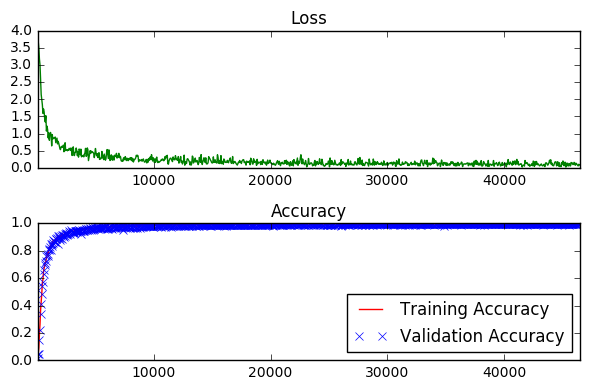

Training done
CPU times: user 2h 5min 50s, sys: 31min 57s, total: 2h 37min 48s
Wall time: 2h 5min 34s


In [19]:
%%time
batches = []
loss_batch = []
train_acc_batch = []
valid_acc_batch = []
log_batch_step = 50

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            _, l = sess.run([training_operation, loss_operation], feed_dict={x: batch_x, y: batch_y, keep_prob:0.5})
            
            # Log every 50 batches
            if not offset % log_batch_step:
                # Calculate Training and Validation accuracy
                training_accuracy = evaluate(X_train, y_train)
                validation_accuracy = evaluate(X_val, y_val)

                # Log batches
                previous_batch = batches[-1] if batches else 0
                batches.append(log_batch_step + previous_batch)
                loss_batch.append(l)
                train_acc_batch.append(training_accuracy)
                valid_acc_batch.append(validation_accuracy)

                
        
        print("EPOCH {} ...".format(i+1))
        training_accuracy = evaluate(X_train, y_train)
        print("Training Accuracy = {:.3f}".format(training_accuracy))
        validation_accuracy = evaluate(X_val, y_val)
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
                
                        
    saver.save(sess, 'traffic_model')
    print("Model saved")
    
loss_plot = plt.subplot(211)
loss_plot.set_title('Loss')
loss_plot.plot(batches, loss_batch, 'g')
loss_plot.set_xlim([batches[0], batches[-1]])
acc_plot = plt.subplot(212)
acc_plot.set_title('Accuracy')
acc_plot.plot(batches, train_acc_batch, 'r', label='Training Accuracy')
acc_plot.plot(batches, valid_acc_batch, 'x', label='Validation Accuracy')
acc_plot.set_ylim([0, 1.0])
acc_plot.set_xlim([batches[0], batches[-1]])
acc_plot.legend(loc=4)
plt.tight_layout()
plt.show()    

print('Training done')

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

I used AdamOptimizer. The following are the hyperparameters used:

- EPOCHS: 15
- BATCH_SIZE: 128
- learning_rate: 0.001
- keep_prob: 0.5

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

The model is based on the architecture of LeNet5, which is well known neural network for classifying images. Some modications made include adding dropout to each convolution layer and changing the filter depth. The dimensions of the fully connected layers are also changed. 

The final model was derived by trial and error with different values of the hyperparameters, and those with highest validation accuracy are selecte.  

### Evaluate the model

In [20]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))  
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy on test data = {:.3f}".format(test_accuracy))    

Test Accuracy on test data = 0.935


---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [58]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

In [1]:
image_files = ['yield.png', 'roundabout.png','roundabout1.png', 'deer.png', 'bicycle.png', '60.png', 'no_entry.png','no_entry1.png']
y_test_images = [13, 40, 40, 31, 29, 3, 17, 17]

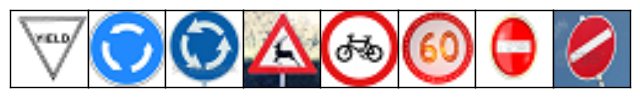

In [5]:
w = len(image_files)
fig = plt.figure(figsize=(w, 1))
gs = gridspec.GridSpec(1, w, wspace=0.0, hspace=0.0)

test_images = np.zeros([len(image_files), 32, 32, 1])
for i in range(w):
    ax = plt.subplot(gs[0, i])
    image = (mpimg.imread('image/' + image_files[i])*255).astype('uint8')    
    ax.set_xticks([])
    ax.set_yticks([])        
    fig.add_subplot(ax)
    image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)   
    image_gray = image_gray.reshape(image_gray.shape + (1,))
    test_images[i,]  = normalize(image_gray)
    
    #ax.imshow(image_gray.squeeze(), cmap='gray')   
    ax.imshow(image)
   
plt.show()    

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



#### Answer:

Some of the images could be difficult to predict. For example, the bicycle image (bicycle.png) has the bicyle surrounded by a circle. It seems all the training example for the bicycle class have the bicycle inside a triangle. The classifier may have not learned to ignore the shape of the surrounding triangle or circle.

The first roundabout image (roundabout.png) may also be difficult for the classifer, as the arrows are very thick and the direction of the arrows are not very prominent, while in training data the arrows seem to be very thin and easy to identify. 

### Run the predictions here.
### Feel free to use as many code cells as needed.

In [61]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    pred = sess.run(tf.argmax(logits, 1), feed_dict={x: test_images, keep_prob: 1.0})     

for i in range(len(image_files)):
    print("Prediction for {} (true class={}): class={}, label={}".format(image_files[i], y_test_images[i], pred[i], signDict[str(pred[i])]))     

Prediction for yield.png (true class=13): class=13, label=Yield
Prediction for roundabout.png (true class=40): class=7, label=Speed limit (100km/h)
Prediction for roundabout1.png (true class=40): class=40, label=Roundabout mandatory
Prediction for deer.png (true class=31): class=31, label=Wild animals crossing
Prediction for bicycle.png (true class=29): class=41, label=End of no passing
Prediction for 60.png (true class=3): class=3, label=Speed limit (60km/h)
Prediction for no_entry.png (true class=17): class=17, label=No entry
Prediction for no_entry1.png (true class=17): class=17, label=No entry


### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

In [62]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(test_images, y_test_images)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.750


The model does not perform as well as on the test data.

In [63]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

In [64]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    pred_op = tf.nn.top_k(tf.nn.softmax(logits), k=3) #[1][0]
    pred = sess.run(pred_op, feed_dict={x: test_images, keep_prob: 1.0})    
    
for i in range(len(image_files)):
    print("Top 3 class predictions for {}:".format(image_files[i]))
    for j in range(3):    
        print("\tclass ID: {}, label: {}, probability: {}".format(pred[1][i][j], signDict[str(pred[1][i][j])], pred[0][i][j]))  

Top 3 class predictions for yield.png:
	class ID: 13, label: Yield, probability: 0.9999992847442627
	class ID: 35, label: Ahead only, probability: 6.185919119161554e-07
	class ID: 14, label: Stop, probability: 4.377991658088831e-08
Top 3 class predictions for roundabout.png:
	class ID: 7, label: Speed limit (100km/h), probability: 0.9973414540290833
	class ID: 12, label: Priority road, probability: 0.0026577271055430174
	class ID: 40, label: Roundabout mandatory, probability: 8.114955676319369e-07
Top 3 class predictions for roundabout1.png:
	class ID: 40, label: Roundabout mandatory, probability: 0.8873307108879089
	class ID: 12, label: Priority road, probability: 0.1116812601685524
	class ID: 7, label: Speed limit (100km/h), probability: 0.0009880105499178171
Top 3 class predictions for deer.png:
	class ID: 31, label: Wild animals crossing, probability: 0.9994214773178101
	class ID: 21, label: Double curve, probability: 0.0005757946637459099
	class ID: 23, label: Slippery road, proba

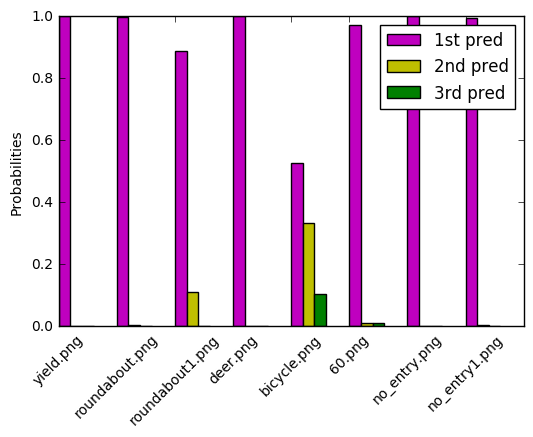

In [65]:
fig, ax = plt.subplots()
plt.xticks(rotation=45)
width = 0.2
bar1 = ax.bar(np.arange(len(image_files)), pred[0][:, 0], width, color='m')
bar2 = ax.bar(np.arange(len(image_files)) + width, pred[0][:, 1], width, color='y')
bar3 = ax.bar(np.arange(len(image_files)) + 2 * width, pred[0][:, 2], width, color='g')

ax.set_ylabel('Probabilities')
ax.set_xticklabels(image_files)
ax.legend((bar1[0], bar2[0], bar3[0]), ('1st pred', '2nd pred', '3rd pred'))

plt.show()  

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

The model correctly predicts 6 out of 8 images.

For the 6 correctly predicted images, the model is very certain. The lowest first prediction probablity is 88.7% and the other 5 images have first prediction probability higher than 97%. 

For the two incorrect predicted images:
- roundabout.png: the model is very certain on the first prediciton with probability 99.7%. The correct prediction is in top 3 though.
- bicycle.png: the model is not certain on the predicitons. The first prediction has probablity 53%, and the correct prediction is not in top 3.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.